# Assignment 02: 4D-STEM Foundations - Complete Solution

## MAT SCI 465 - Computational Microscopy

This notebook implements a modular Python framework for 4D-STEM data analysis with:
- Virtual detector framework (BF, ADF, custom masks)
- Diffraction analysis functions
- Complete analysis pipeline
- Application to Si/SiGe heterostructure data

In [1]:
# Setup and imports
import sys
if 'google.colab' in sys.modules:
    print("Running in Google Colab. Installing requirements...")
    !pip install -q py4DSTEM hyperspy scikit-image matplotlib numpy scipy
else:
    print("Running in local environment")

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from matplotlib.colors import Normalize
from scipy import ndimage
from scipy.interpolate import interp1d
import py4DSTEM
import warnings
warnings.filterwarnings('ignore')

# Set up matplotlib for publication-quality figures
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14

def _walk_dicts(d):
    stack = [d]
    while stack:
        cur = stack.pop()
        yield cur
        for v in cur.values():
            if isinstance(v, dict):
                stack.append(v)


def _find_in_metadata(meta_sources, keys):
    for src in meta_sources:
        for d in _walk_dicts(src):
            for k in keys:
                if k in d:
                    return k, d[k]
    return None, None


def _to_float(v):
    try:
        return float(v)
    except Exception:
        return None


def electron_wavelength_nm_from_kv(voltage_kv):
    # Relativistic electron wavelength in nm
    V = float(voltage_kv) * 1e3
    h = 6.62607015e-34
    m = 9.10938356e-31
    e = 1.602176634e-19
    c = 299792458.0
    lam_m = h / np.sqrt(2 * m * e * V * (1 + (e * V) / (2 * m * c**2)))
    return lam_m * 1e9


def resolve_calibration(data, calibration=None, fallback_scan_step_nm=1.0, verbose=True):
    
    cal = dict(calibration or {})

    meta_sources = []
    for attr in ('metadata', 'calibration', 'meta'):
        src = getattr(data, attr, None)
        if isinstance(src, dict):
            meta_sources.append(src)

    # --- scan step (nm) ---
    if 'scan_step_nm' not in cal:
        k, v = _find_in_metadata(meta_sources, [
            'scan_step_nm', 'scan_step_size_nm', 'scan_step', 'scan_step_size',
            'step_nm', 'step_size_nm', 'scan_step_m', 'scan_step_size_m',
            'step_m', 'step_size_m', 'scan_step_um', 'scan_step_mm'
        ])
        val = _to_float(v)
        if val is not None:
            if k.endswith('_m'):
                cal['scan_step_nm'] = val * 1e9
            elif k.endswith('_um'):
                cal['scan_step_nm'] = val * 1e3
            elif k.endswith('_mm'):
                cal['scan_step_nm'] = val * 1e6
            else:
                cal['scan_step_nm'] = val

    if 'scan_step_nm' not in cal:
        cal['scan_step_nm'] = fallback_scan_step_nm
        if verbose:
            print(f"Calibration warning: scan_step_nm missing; using fallback {fallback_scan_step_nm} nm")

    # --- camera length (m) ---
    if 'camera_length_m' not in cal:
        k, v = _find_in_metadata(meta_sources, ['camera_length_m', 'camera_length_mm', 'camera_length'])
        val = _to_float(v)
        if val is not None:
            if k.endswith('_mm') or (k == 'camera_length' and val > 1):
                cal['camera_length_m'] = val * 1e-3
            else:
                cal['camera_length_m'] = val

    # --- detector pixel size (m) ---
    if 'detector_pixel_size_m' not in cal:
        k, v = _find_in_metadata(meta_sources, [
            'detector_pixel_size_m', 'detector_pixel_size_um', 'detector_pixel_size_nm',
            'pixel_size_m', 'pixel_size_um', 'pixel_size_nm', 'detector_pixel_size'
        ])
        val = _to_float(v)
        if val is not None:
            if k.endswith('_um'):
                cal['detector_pixel_size_m'] = val * 1e-6
            elif k.endswith('_nm'):
                cal['detector_pixel_size_m'] = val * 1e-9
            elif k.endswith('_m'):
                cal['detector_pixel_size_m'] = val
            else:
                # Heuristic: assume meters if very small, otherwise microns
                cal['detector_pixel_size_m'] = val if val < 1e-2 else val * 1e-6

    # --- electron wavelength (nm) ---
    if 'electron_wavelength_nm' not in cal:
        k, v = _find_in_metadata(meta_sources, ['electron_wavelength_nm', 'wavelength_nm', 'lambda_nm'])
        val = _to_float(v)
        if val is not None:
            cal['electron_wavelength_nm'] = val

    # --- accelerating voltage (kV) ---
    if 'accelerating_voltage_kv' not in cal:
        k, v = _find_in_metadata(meta_sources, ['accelerating_voltage_kv', 'voltage_kv', 'ht_kv', 'accelerating_voltage', 'voltage'])
        val = _to_float(v)
        if val is not None:
            cal['accelerating_voltage_kv'] = val / 1e3 if val > 1e3 else val

    if 'electron_wavelength_nm' not in cal and 'accelerating_voltage_kv' in cal:
        cal['electron_wavelength_nm'] = electron_wavelength_nm_from_kv(cal['accelerating_voltage_kv'])

    # --- k-space calibration (nm^-1 per pixel) ---
    if 'k_pixel_inv_nm' not in cal:
        k, v = _find_in_metadata(meta_sources, [
            'k_pixel_inv_nm', 'k_pixel_size_inv_nm', 'q_pixel_inv_nm',
            'k_pixel_inv_A', 'k_pixel_inv_angstrom', 'q_pixel_inv_A'
        ])
        val = _to_float(v)
        if val is not None:
            if k.endswith('inv_A') or 'inv_A' in k or 'inv_angstrom' in k:
                cal['k_pixel_inv_nm'] = val * 10.0
            else:
                cal['k_pixel_inv_nm'] = val

    if 'k_pixel_inv_nm' not in cal:
        cam = cal.get('camera_length_m')
        pix = cal.get('detector_pixel_size_m')
        lam_nm = cal.get('electron_wavelength_nm')
        if cam and pix and lam_nm:
            theta_per_pixel = pix / cam  # radians
            mrad_per_pixel = theta_per_pixel * 1e3
            lam_m = lam_nm * 1e-9
            q_per_pixel_inv_m = (2 * np.pi / lam_m) * theta_per_pixel
            cal['k_pixel_inv_nm'] = q_per_pixel_inv_m * 1e-9
            cal['mrad_per_pixel'] = mrad_per_pixel
            if verbose:
                print(
                    f"Calibration: derived k_pixel_inv_nm={cal['k_pixel_inv_nm']:.4f}, "
                    f"mrad_per_pixel={cal['mrad_per_pixel']:.3f}"
                )
        else:
            cal['k_pixel_inv_nm'] = 0.1  # 0.01 A^-1 per pixel
            cal['mrad_per_pixel'] = 0.4
            if verbose:
                print("Calibration warning: insufficient metadata for k-space; using fallback k_pixel_inv_nm=0.1")

    if 'mrad_per_pixel' not in cal:
        q_per_pixel_inv_A = cal['k_pixel_inv_nm'] * 0.1
        cal['mrad_per_pixel'] = q_per_pixel_inv_A / 0.025

    return cal


Running in local environment


---
## Task 1: Virtual Detector Framework

The `VirtualDetector` class provides a flexible framework for creating and applying virtual detectors to 4D-STEM data.

In [2]:
class VirtualDetector:
    """
    Virtual detector for 4D-STEM data analysis.
    
    Supports Bright Field (BF), Annular Dark Field (ADF), and custom mask geometries.
    
    Parameters
    ----------
    name : str
        Name identifier for the detector
    center : tuple of float
        (x, y) center coordinates in pixels
    inner_radius : float
        Inner radius in pixels (0 for BF detector)
    outer_radius : float, optional
        Outer radius in pixels (None for circular, required for annular)
    """
    
    def __init__(self, name, center, inner_radius, outer_radius=None):
        self.name = name
        self.center = center
        self.inner_radius = inner_radius
        self.outer_radius = outer_radius if outer_radius is not None else inner_radius
        self._mask = None
        self._mask_shape = None
        
        if inner_radius == 0:
            self.detector_type = 'BF'  # Bright Field
        elif outer_radius is not None and inner_radius > 0:
            self.detector_type = 'ADF'  # Annular Dark Field
        else:
            self.detector_type = 'circular'
    
    def create_mask(self, shape):
        """
        Create a 2D binary mask for the detector.
        
        Parameters
        ----------
        shape : tuple
            (height, width) of the diffraction pattern
            
        Returns
        -------
        mask : ndarray
            2D boolean mask array
        """
        # Use cached mask if shape matches
        if self._mask is not None and self._mask_shape == shape:
            return self._mask
        
        ny, nx = shape
        y, x = np.ogrid[:ny, :nx]
        
        # Calculate distance from center
        cx, cy = self.center
        r = np.sqrt((x - cx)**2 + (y - cy)**2)
        
        # Create annular or circular mask
        if self.inner_radius == 0:
            # Circular mask (BF)
            mask = r <= self.outer_radius
        else:
            # Annular mask (ADF)
            mask = (r >= self.inner_radius) & (r <= self.outer_radius)
        
        self._mask = mask
        self._mask_shape = shape
        return mask
    
    def _auto_clip_radii(self, data_shape):
        """
        Auto-clip radii to fit within data bounds.
        
        Parameters
        ----------
        data_shape : tuple
            Shape of diffraction pattern (ny, nx)
        """
        ny, nx = data_shape
        cx, cy = self.center
        
        max_r = min(cx, cy, nx - 1 - cx, ny - 1 - cy)
        
        self.outer_radius = min(self.outer_radius, int(max_r) - 1)
        
        # Clip inner radius (must be < outer)
        if self.inner_radius > 0:
            self.inner_radius = min(self.inner_radius, self.outer_radius - 1)
        
        # Clear cached mask since radii changed
        self._mask = None
        self._mask_shape = None
    
    def validate_geometry(self, data_shape):
        """
        Validate that detector geometry fits within reciprocal space FOV.
        Auto-clips radii if needed, raises ValueError if still invalid.
        
        Parameters
        ----------
        data_shape : tuple
            Shape of diffraction pattern (ny, nx)
            
        Returns
        -------
        valid : bool
            True if geometry is valid (after auto-clipping)
        """
        ny, nx = data_shape
        cx, cy = self.center
        
        # Check if center is within bounds
        if not (0 <= cx < nx and 0 <= cy < ny):
            raise ValueError(f"{self.name}: center ({cx}, {cy}) is outside data bounds ({nx}, {ny})")
        
        # Calculate max possible radius
        max_r = min(cx, cy, nx - 1 - cx, ny - 1 - cy)
        
        if self.outer_radius > max_r:
            print(f"Auto-clipping {self.name}: outer_radius {self.outer_radius:.1f} -> {int(max_r)-1}")
            self._auto_clip_radii(data_shape)
        
        # Final validation after clipping
        if self.outer_radius < 2:
            raise ValueError(f"{self.name}: outer_radius ({self.outer_radius}) too small (must be >= 2)")
        
        if self.inner_radius < 0:
            raise ValueError(f"{self.name}: inner_radius ({self.inner_radius}) cannot be negative")
        
        if self.detector_type == 'ADF' and self.inner_radius >= self.outer_radius:
            raise ValueError(f"{self.name}: inner_radius ({self.inner_radius}) must be < outer_radius ({self.outer_radius})")
        
        return True
    
    def apply(self, data_4d):
        """
        Apply virtual detector to 4D-STEM data to generate virtual image.
        
        Parameters
        ----------
        data_4d : ndarray
            4D-STEM data with shape (scan_y, scan_x, diff_y, diff_x)
            
        Returns
        -------
        virtual_image : ndarray
            2D virtual image with shape (scan_y, scan_x)
        """
        # Convert to numpy array 
        data_4d = np.asarray(data_4d)
        
        # Get data shape
        scan_y, scan_x, diff_y, diff_x = data_4d.shape
        
        # Create mask for diffraction pattern
        mask = self.create_mask((diff_y, diff_x))
        
        # Apply mask and sum - vectorized for efficiency
        data_reshaped = data_4d.reshape(-1, diff_y, diff_x)
        
        # Apply mask and sum over diffraction dimensions
        virtual_flat = np.sum(data_reshaped * mask, axis=(1, 2))
        
        # Reshape back to scan dimensions
        virtual_image = virtual_flat.reshape(scan_y, scan_x)
        
        return virtual_image
    
    def visualize_mask(self, shape, ax=None):
        """
        Visualize the detector mask.
        
        Parameters
        ----------
        shape : tuple
            Shape of diffraction pattern
        ax : matplotlib axis, optional
            Axis to plot on
        """
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        
        mask = self.create_mask(shape)
        ax.imshow(mask, cmap='gray', origin='lower')
        ax.set_title(f'{self.name} Detector Mask')
        ax.set_xlabel('kx (pixels)')
        ax.set_ylabel('ky (pixels)')
        
        # Mark center
        ax.plot(self.center[0], self.center[1], 'r+', markersize=10, markeredgewidth=2)
        
        return ax
    
    def __repr__(self):
        return (f"VirtualDetector(name='{self.name}', type='{self.detector_type}', "
                f"center={self.center}, inner_r={self.inner_radius}, outer_r={self.outer_radius})")

VirtualDetector(name='BF', type='BF', center=(64, 64), inner_r=0, outer_r=20)
VirtualDetector(name='ADF', type='ADF', center=(64, 64), inner_r=30, outer_r=60)

BF mask shape: (128, 128), pixels in mask: 1257
ADF mask shape: (128, 128), pixels in mask: 8480

BF geometry valid: True
ADF geometry valid: True


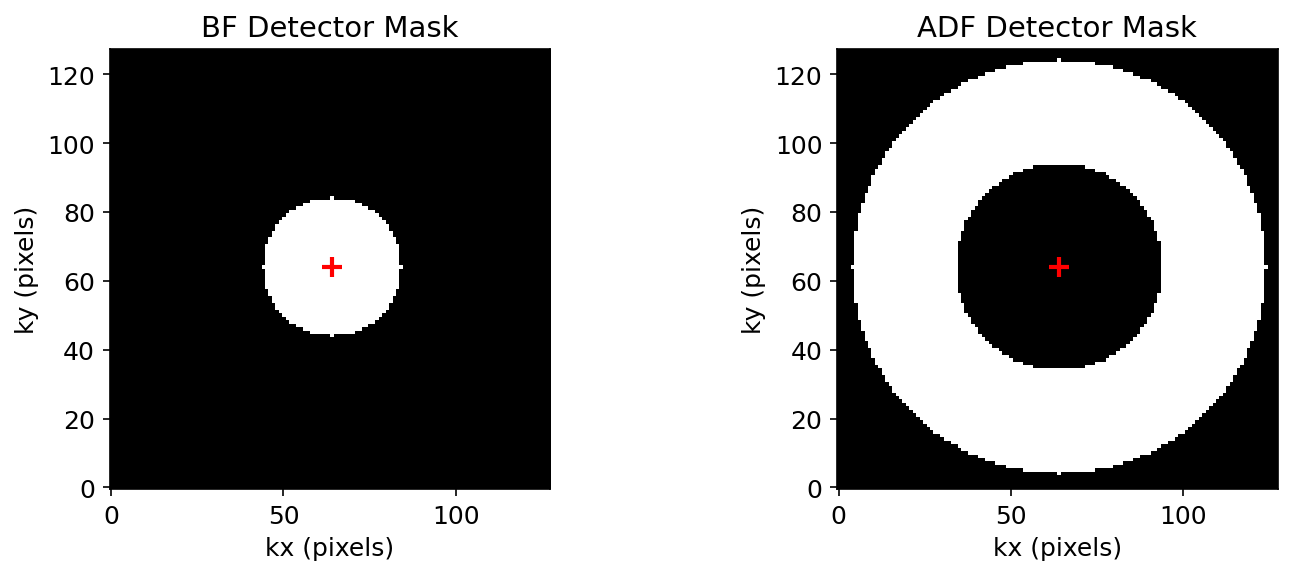

In [3]:
# Create test detectors
bf_detector = VirtualDetector('BF', center=(64, 64), inner_radius=0, outer_radius=20)
adf_detector = VirtualDetector('ADF', center=(64, 64), inner_radius=30, outer_radius=60)

print(bf_detector)
print(adf_detector)

# Test mask creation
test_shape = (128, 128)
bf_mask = bf_detector.create_mask(test_shape)
adf_mask = adf_detector.create_mask(test_shape)

print(f"\nBF mask shape: {bf_mask.shape}, pixels in mask: {bf_mask.sum()}")
print(f"ADF mask shape: {adf_mask.shape}, pixels in mask: {adf_mask.sum()}")

# Validate geometries
print(f"\nBF geometry valid: {bf_detector.validate_geometry(test_shape)}")
print(f"ADF geometry valid: {adf_detector.validate_geometry(test_shape)}")

# Visualize masks
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
bf_detector.visualize_mask(test_shape, ax=axes[0])
adf_detector.visualize_mask(test_shape, ax=axes[1])
plt.tight_layout()
plt.show()

---
## Task 2: Diffraction Analysis Functions

Standalone functions for analyzing individual diffraction patterns.

In [4]:
def calculate_total_intensity(pattern):
    """
    Calculate total integrated intensity of a diffraction pattern.
    
    Parameters
    ----------
    pattern : ndarray
        2D diffraction pattern
        
    Returns
    -------
    total : float
        Sum of all pixel intensities
    """
    return np.sum(pattern)


def calculate_center_of_mass(pattern):
    """
    Calculate center of mass of a diffraction pattern.
    
    Parameters
    ----------
    pattern : ndarray
        2D diffraction pattern
        
    Returns
    -------
    com : tuple
        (x, y) center of mass coordinates
    """
    # Use scipy's center of mass calculation
    com_y, com_x = ndimage.center_of_mass(pattern)
    return (com_x, com_y)


def calculate_radial_profile(pattern, center=None):
    """
    Calculate azimuthally averaged radial intensity profile.
    
    Parameters
    ----------
    pattern : ndarray
        2D diffraction pattern
    center : tuple, optional
        (x, y) center coordinates. If None, uses pattern center.
        
    Returns
    -------
    radii : ndarray
        Array of radial distances in pixels
    profile : ndarray
        Azimuthally averaged intensity at each radius
    """
    ny, nx = pattern.shape
    
    if center is None:
        center = (nx / 2, ny / 2)
    
    cx, cy = center
    
    # Create coordinate grids
    y, x = np.ogrid[:ny, :nx]
    r = np.sqrt((x - cx)**2 + (y - cy)**2)
    
    # Bin the radii to integers
    r_int = r.astype(int)
    max_r = int(np.max(r_int)) + 1
    
    # Calculate radial profile using binned statistics
    radii = np.arange(max_r)
    profile = np.zeros(max_r)
    counts = np.zeros(max_r)
    
    # Use numpy bincount for efficient summation
    np.add.at(profile, r_int.ravel(), pattern.ravel())
    np.add.at(counts, r_int.ravel(), 1)
    
    # Avoid division by zero
    counts[counts == 0] = 1
    profile = profile / counts
    
    return radii, profile


def calibrate_reciprocal_space(pixel_size_inv_nm=None, camera_length_mm=None, 
                                wavelength_nm=None, pixel_size_um=None):
    """
    Calculate reciprocal space calibration.
    
    Can either use direct pixel size in reciprocal space, or calculate from
    camera geometry.
    
    Parameters
    ----------
    pixel_size_inv_nm : float, optional
        Direct reciprocal space pixel size in nm^-1
    camera_length_mm : float, optional
        Camera length in mm
    wavelength_nm : float, optional
        Electron wavelength in nm
    pixel_size_um : float, optional
        Detector pixel size in micrometers
        
    Returns
    -------
    calibration : dict
        Dictionary with reciprocal space calibration:
        - 'pixel_size_inv_nm': size in nm^-1
        - 'pixel_size_inv_A': size in Å^-1
        - 'pixel_size_mrad': size in mrad
    """
    if pixel_size_inv_nm is not None:
        # Direct calibration provided
        k_per_pixel = pixel_size_inv_nm  # nm^-1
    elif all(v is not None for v in [camera_length_mm, wavelength_nm, pixel_size_um]):
        # Calculate from camera geometry
        # k = theta / wavelength, where theta ≈ pixel_size / camera_length (small angle)
        camera_length_um = camera_length_mm * 1000
        theta_per_pixel = pixel_size_um / camera_length_um  # radians
        k_per_pixel = theta_per_pixel / wavelength_nm  # nm^-1
    else:
        raise ValueError("Must provide either pixel_size_inv_nm or all of "
                        "(camera_length_mm, wavelength_nm, pixel_size_um)")
    
    # Convert to different units
    calibration = {
        'pixel_size_inv_nm': k_per_pixel,
        'pixel_size_inv_A': k_per_pixel / 10,  # nm^-1 to Å^-1
        'pixel_size_mrad': k_per_pixel * wavelength_nm * 1000 if wavelength_nm else None
    }
    
    return calibration

Total intensity: 1087995.17
Center of mass: (63.97, 63.97)
Expected center: (64, 64)

Calibration: {'pixel_size_inv_nm': 0.05, 'pixel_size_inv_A': 0.005, 'pixel_size_mrad': None}


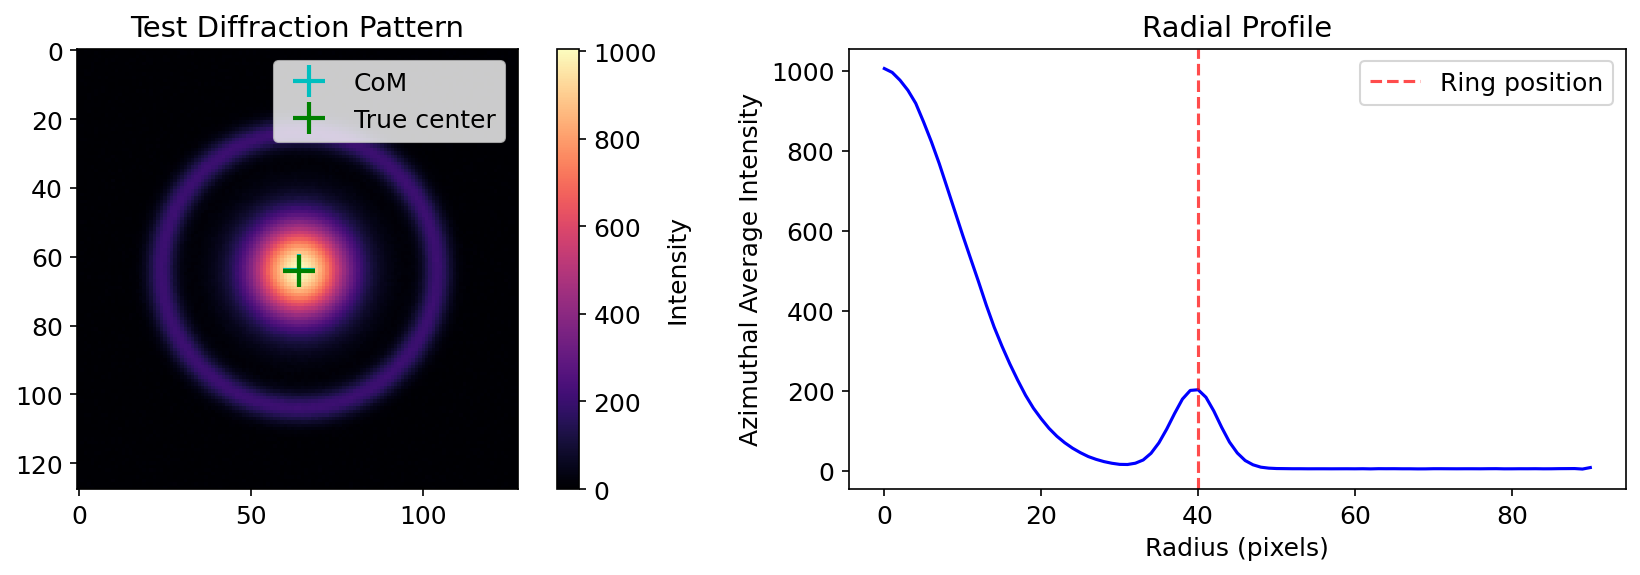

In [5]:
# Create a synthetic diffraction pattern (Gaussian spot + ring)
test_pattern = np.zeros((128, 128))
y, x = np.ogrid[:128, :128]
center = (64, 64)
r = np.sqrt((x - center[0])**2 + (y - center[1])**2)

# Central spot
test_pattern += 1000 * np.exp(-r**2 / (2 * 10**2))
# Diffraction ring
test_pattern += 200 * np.exp(-(r - 40)**2 / (2 * 3**2))
# Add some noise
test_pattern += np.random.poisson(5, (128, 128))

# Test functions
total_intensity = calculate_total_intensity(test_pattern)
com = calculate_center_of_mass(test_pattern)
radii, profile = calculate_radial_profile(test_pattern, center)

print(f"Total intensity: {total_intensity:.2f}")
print(f"Center of mass: ({com[0]:.2f}, {com[1]:.2f})")
print(f"Expected center: {center}")

# Test calibration
# For 200 kV electrons: wavelength ≈ 0.00251 nm
calib = calibrate_reciprocal_space(pixel_size_inv_nm=0.05)
print(f"\nCalibration: {calib}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Diffraction pattern
im = axes[0].imshow(test_pattern, cmap='magma', norm=Normalize(vmin=0))
axes[0].plot(com[0], com[1], 'c+', markersize=15, markeredgewidth=2, label='CoM')
axes[0].plot(center[0], center[1], 'g+', markersize=15, markeredgewidth=2, label='True center')
axes[0].legend()
axes[0].set_title('Test Diffraction Pattern')
plt.colorbar(im, ax=axes[0], label='Intensity')

# Radial profile
axes[1].plot(radii, profile, 'b-', linewidth=1.5)
axes[1].set_xlabel('Radius (pixels)')
axes[1].set_ylabel('Azimuthal Average Intensity')
axes[1].set_title('Radial Profile')
axes[1].axvline(40, color='r', linestyle='--', alpha=0.7, label='Ring position')
axes[1].legend()

plt.tight_layout()
plt.show()

---
## Task 3: Analysis Pipeline

The `run_pipeline()` function orchestrates the complete 4D-STEM analysis workflow.

In [6]:
def run_pipeline(data, detectors, calibration=None, compute_stats=True, verbose=True):
    """
    Run complete 4D-STEM analysis pipeline.
    
    Parameters
    ----------
    data : ndarray or py4DSTEM.DataCube
        4D-STEM data with shape (scan_y, scan_x, diff_y, diff_x)
    detectors : list of VirtualDetector
        Virtual detectors to apply
    calibration : dict, optional
        Calibration information with keys:
        - 'scan_step_nm': real space scan step in nm
        - 'k_pixel_inv_nm': reciprocal space pixel size in nm^-1
    compute_stats : bool
        Whether to compute diffraction statistics for each scan position
    verbose : bool
        Print progress information
        
    Returns
    -------
    results : dict
        Dictionary containing:
        - 'virtual_images': dict of virtual images keyed by detector name
        - 'diffraction_stats': dict with CoM, total intensity maps
        - 'metadata': calibration and data info
    """
    # Handle py4DSTEM DataCube and ensure numpy array
    if hasattr(data, 'data'):
        data_array = np.asarray(data.data)
    else:
        data_array = np.asarray(data)
    
    scan_y, scan_x, diff_y, diff_x = data_array.shape
    
    if verbose:
        print(f"Running pipeline on data with shape: {data_array.shape}")
        print(f"  Scan dimensions: {scan_y} x {scan_x}")
        print(f"  Diffraction dimensions: {diff_y} x {diff_x}")
        print(f"  Number of detectors: {len(detectors)}")
    
    resolved_cal = resolve_calibration(data, calibration=calibration, fallback_scan_step_nm=1.0, verbose=verbose)

    results = {
        'virtual_images': {},
        'diffraction_stats': {},
        'metadata': {
            'data_shape': data_array.shape,
            'scan_shape': (scan_y, scan_x),
            'diffraction_shape': (diff_y, diff_x),
            'calibration': resolved_cal
        }
    }
    
    # Validate and apply each detector
    for detector in detectors:
        if verbose:
            print(f"\nApplying detector: {detector.name}")
        
        # Validate geometry
        if not detector.validate_geometry((diff_y, diff_x)):
            print(f"  Warning: Detector geometry validation failed, proceeding anyway")
        
        # Apply detector
        virtual_image = detector.apply(data_array)
        results['virtual_images'][detector.name] = virtual_image
        
        if verbose:
            print(f"  Virtual image range: [{virtual_image.min():.2f}, {virtual_image.max():.2f}]")
    
    # Compute diffraction statistics if requested
    if compute_stats:
        if verbose:
            print("\nComputing diffraction statistics...")
        
        # Initialize arrays
        total_intensity_map = np.zeros((scan_y, scan_x))
        com_x_map = np.zeros((scan_y, scan_x))
        com_y_map = np.zeros((scan_y, scan_x))
        
        # Compute for each scan position
        for iy in range(scan_y):
            for ix in range(scan_x):
                pattern = data_array[iy, ix]
                
                # Total intensity
                total_intensity_map[iy, ix] = calculate_total_intensity(pattern)
                
                # Center of mass
                com = calculate_center_of_mass(pattern)
                com_x_map[iy, ix] = com[0]
                com_y_map[iy, ix] = com[1]
        
        results['diffraction_stats'] = {
            'total_intensity': total_intensity_map,
            'com_x': com_x_map,
            'com_y': com_y_map
        }
        
        if verbose:
            mean_com = (np.mean(com_x_map), np.mean(com_y_map))
            print(f"  Mean CoM: ({mean_com[0]:.2f}, {mean_com[1]:.2f})")
    
    if verbose:
        print("\nPipeline complete!")
    
    return results

Running pipeline on data with shape: (16, 16, 64, 64)
  Scan dimensions: 16 x 16
  Diffraction dimensions: 64 x 64
  Number of detectors: 2
Calibration warning: insufficient metadata for k-space; using fallback k_pixel_inv_nm=0.1

Applying detector: BF
  Virtual image range: [142480.24, 246215.21]

Applying detector: ADF
  Virtual image range: [165052.95, 338133.98]

Computing diffraction statistics...
  Mean CoM: (31.86, 31.86)

Pipeline complete!


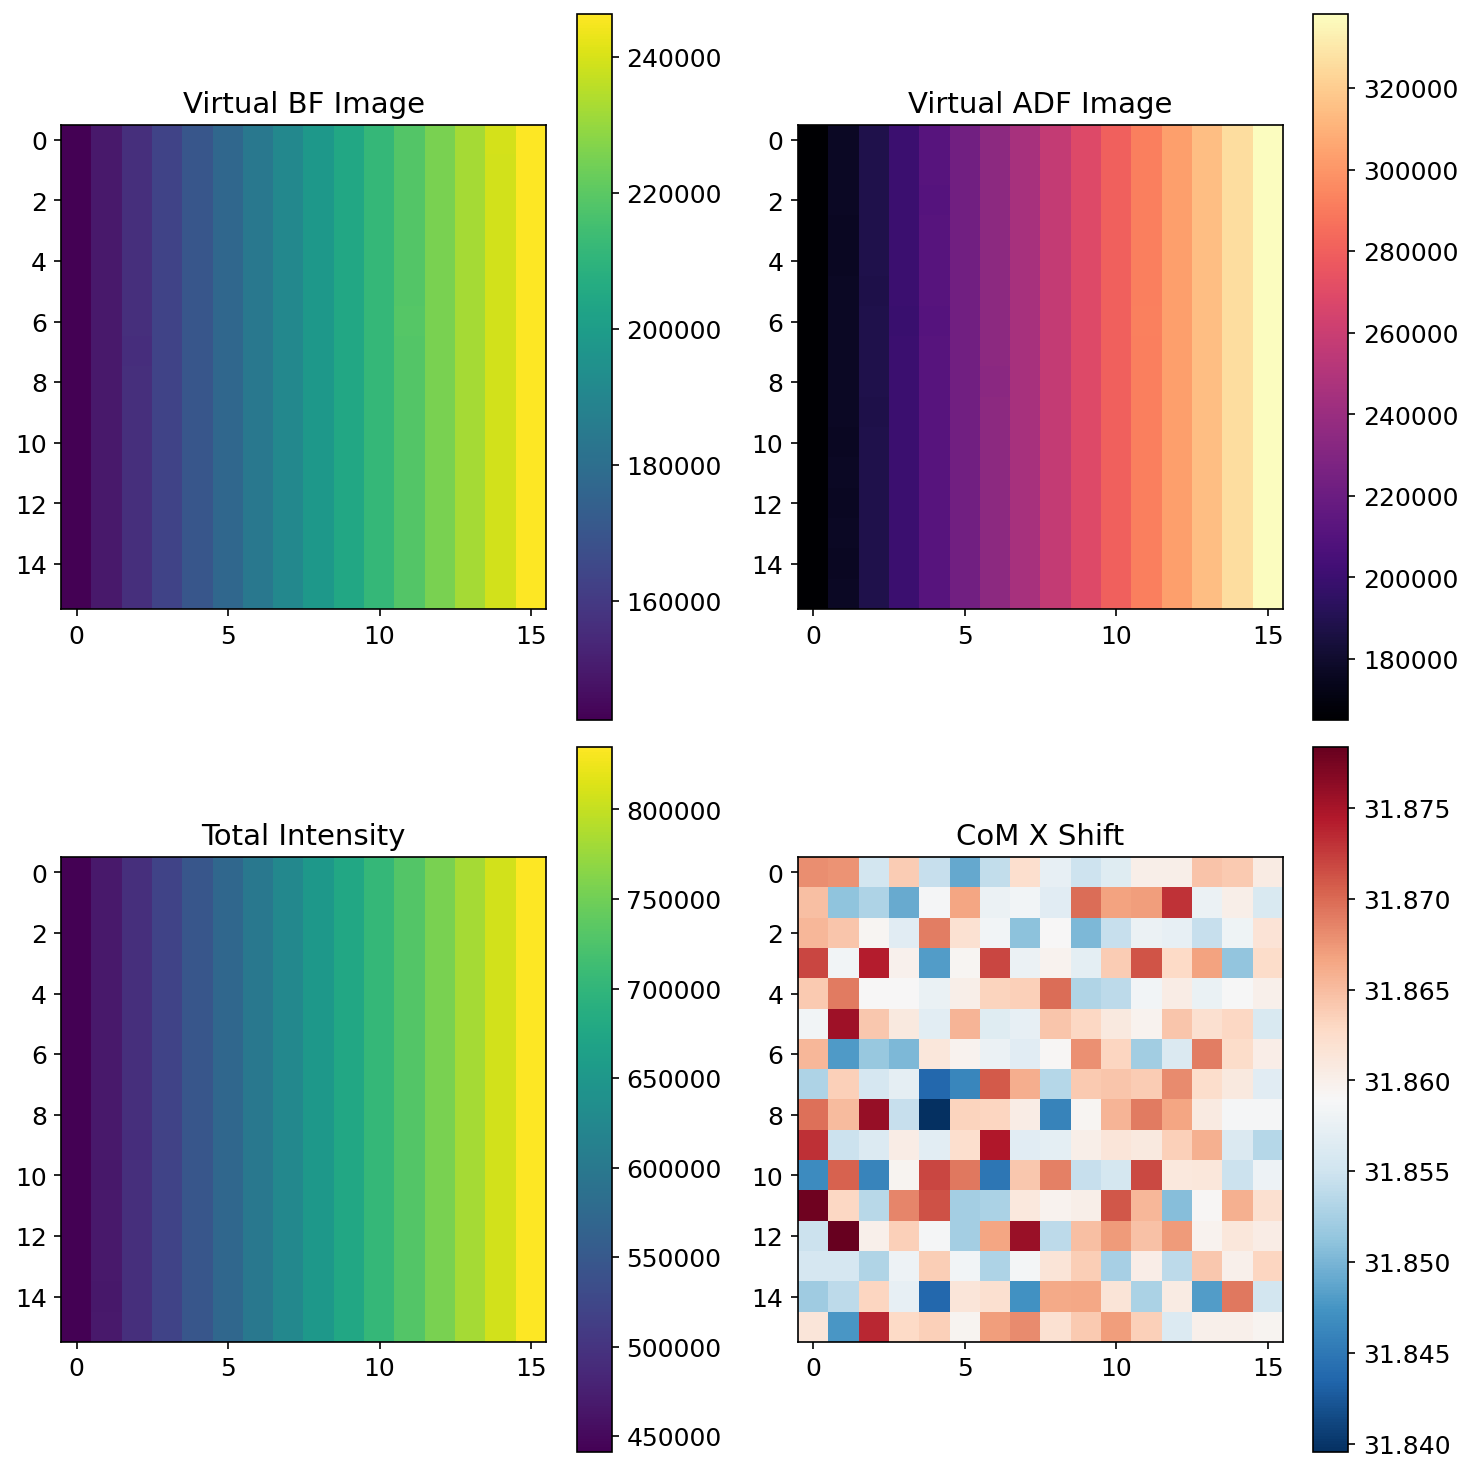

In [7]:
# Create synthetic 4D-STEM data
scan_y, scan_x = 16, 16
diff_y, diff_x = 64, 64

synthetic_data = np.zeros((scan_y, scan_x, diff_y, diff_x))
y, x = np.ogrid[:diff_y, :diff_x]
center = (diff_x // 2, diff_y // 2)
r = np.sqrt((x - center[0])**2 + (y - center[1])**2)

# Create patterns with varying intensity (simulate interface)
for iy in range(scan_y):
    for ix in range(scan_x):
        # Intensity varies across x (simulating interface)
        base_intensity = 500 + 300 * (ix / scan_x)
        scatter_intensity = 100 + 150 * (ix / scan_x)  
        
        # Central beam
        synthetic_data[iy, ix] = base_intensity * np.exp(-r**2 / (2 * 8**2))
        # Scattered electrons
        synthetic_data[iy, ix] += scatter_intensity * np.exp(-r**2 / (2 * 20**2))
        # Add noise
        synthetic_data[iy, ix] += np.random.poisson(10, (diff_y, diff_x))

# Create detectors
bf_det = VirtualDetector('BF', center=center, inner_radius=0, outer_radius=10)
adf_det = VirtualDetector('ADF', center=center, inner_radius=15, outer_radius=30)

# Run pipeline
test_results = run_pipeline(
    synthetic_data, 
    [bf_det, adf_det],
    calibration={'scan_step_nm': 1.0},
    compute_stats=True
)

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

im0 = axes[0, 0].imshow(test_results['virtual_images']['BF'], cmap='viridis')
axes[0, 0].set_title('Virtual BF Image')
plt.colorbar(im0, ax=axes[0, 0])

im1 = axes[0, 1].imshow(test_results['virtual_images']['ADF'], cmap='magma')
axes[0, 1].set_title('Virtual ADF Image')
plt.colorbar(im1, ax=axes[0, 1])

im2 = axes[1, 0].imshow(test_results['diffraction_stats']['total_intensity'], cmap='viridis')
axes[1, 0].set_title('Total Intensity')
plt.colorbar(im2, ax=axes[1, 0])

im3 = axes[1, 1].imshow(test_results['diffraction_stats']['com_x'], cmap='RdBu_r')
axes[1, 1].set_title('CoM X Shift')
plt.colorbar(im3, ax=axes[1, 1])

plt.tight_layout()
plt.show()

---
## Task 4: Apply to Si/SiGe Dataset

Now we apply our framework to the real Si-SiGe.dm4 dataset.

In [8]:
# Set the data path
data_path = 'Si-SiGe.dm4'

# Load using py4DSTEM
dataset = py4DSTEM.import_file(data_path)

print(f"\nDataset loaded successfully!")
print(f"Type: {type(dataset)}")
print(f"Original data shape: {dataset.data.shape}")

# The smaller dimensions (77x17) are scan positions, larger (448x480) are diffraction pattern pixels
data_4d = np.transpose(np.asarray(dataset.data), (2, 3, 0, 1))
print(f"Transposed shape (scan_y, scan_x, diff_y, diff_x): {data_4d.shape}")


Dataset loaded successfully!
Type: <class 'py4DSTEM.io.datastructure.py4dstem.datacube.DataCube'>
Original data shape: (480, 448, 77, 17)
Transposed shape (scan_y, scan_x, diff_y, diff_x): (77, 17, 480, 448)


In [9]:
# Task 1: Understand Navigation vs Signal Axes

scan_y, scan_x, diff_y, diff_x = data_4d.shape

print(f"\n4D-STEM Data Shape: {data_4d.shape}")
print(f"  - Dimensions 0-1: Navigation axes (scan positions y, x)")
print(f"    Shape: {scan_y} x {scan_x} = {scan_y * scan_x} probe positions")
print(f"  - Dimensions 2-3: Signal axes (diffraction pattern ky, kx)")
print(f"    Shape: {diff_y} x {diff_x} = {diff_y * diff_x} pixels per pattern")

print("\nNavigation Axes: Define WHERE the measurement is made (y,x scan positions in real space)")
print("Signal Axes: Define WHAT is measured at each point (2D diffraction pattern in reciprocal space)")


4D-STEM Data Shape: (77, 17, 480, 448)
  - Dimensions 0-1: Navigation axes (scan positions y, x)
    Shape: 77 x 17 = 1309 probe positions
  - Dimensions 2-3: Signal axes (diffraction pattern ky, kx)
    Shape: 480 x 448 = 215040 pixels per pattern

Navigation Axes: Define WHERE the measurement is made (y,x scan positions in real space)
Signal Axes: Define WHAT is measured at each point (2D diffraction pattern in reciprocal space)


In [10]:
# Task 2: Calibrate the dataset

# Get data dimensions from transposed data
scan_y, scan_x, diff_y, diff_x = data_4d.shape

# Resolve calibration from metadata (with fallback)
calibration = resolve_calibration(dataset, calibration=None, fallback_scan_step_nm=1.0, verbose=True)
scan_step_nm = calibration['scan_step_nm']

print(f"Scan step size: {scan_step_nm} nm")
print(f"Field of view: {scan_x * scan_step_nm:.1f} x {scan_y * scan_step_nm:.1f} nm")

# Calculate mean diffraction pattern for finding beam center
mean_dp = np.mean(data_4d, axis=(0, 1))
print(f"Mean diffraction pattern shape: {mean_dp.shape}")

# Find beam center using Center of Mass
beam_center = calculate_center_of_mass(mean_dp)
print(f"Beam center (CoM): ({beam_center[0]:.2f}, {beam_center[1]:.2f})")
print(f"Geometric center: ({diff_x/2:.2f}, {diff_y/2:.2f})")

# Calculate shift from geometric center
shift_x = beam_center[0] - diff_x / 2
shift_y = beam_center[1] - diff_y / 2
print(f"Beam shift from center: ({shift_x:.2f}, {shift_y:.2f}) pixels")

# CoM-based beam centering (global shift)
if np.hypot(shift_x, shift_y) > 0.1:
    print("Applying global beam-centering shift to all diffraction patterns...")
    data_4d_centered = ndimage.shift(
        data_4d,
        shift=(0, 0, -shift_y, -shift_x),
        order=1,
        mode='nearest'
    )

    # Recompute mean DP and CoM after centering
    mean_dp_centered = np.mean(data_4d_centered, axis=(0, 1))
    beam_center_centered = calculate_center_of_mass(mean_dp_centered)
    print(f"Centered beam CoM: ({beam_center_centered[0]:.2f}, {beam_center_centered[1]:.2f})")

    # Update references for downstream analysis
    data_4d = data_4d_centered
    mean_dp = mean_dp_centered
    beam_center = beam_center_centered
else:
    print("Beam shift is small; skipping global centering.")

# Store beam center in calibration for downstream use
calibration['beam_center'] = beam_center


Calibration warning: scan_step_nm missing; using fallback 1.0 nm
Calibration warning: insufficient metadata for k-space; using fallback k_pixel_inv_nm=0.1
Scan step size: 1.0 nm
Field of view: 17.0 x 77.0 nm
Mean diffraction pattern shape: (480, 448)
Beam center (CoM): (223.63, 239.72)
Geometric center: (224.00, 240.00)
Beam shift from center: (-0.37, -0.28) pixels
Applying global beam-centering shift to all diffraction patterns...
Centered beam CoM: (223.66, 239.74)


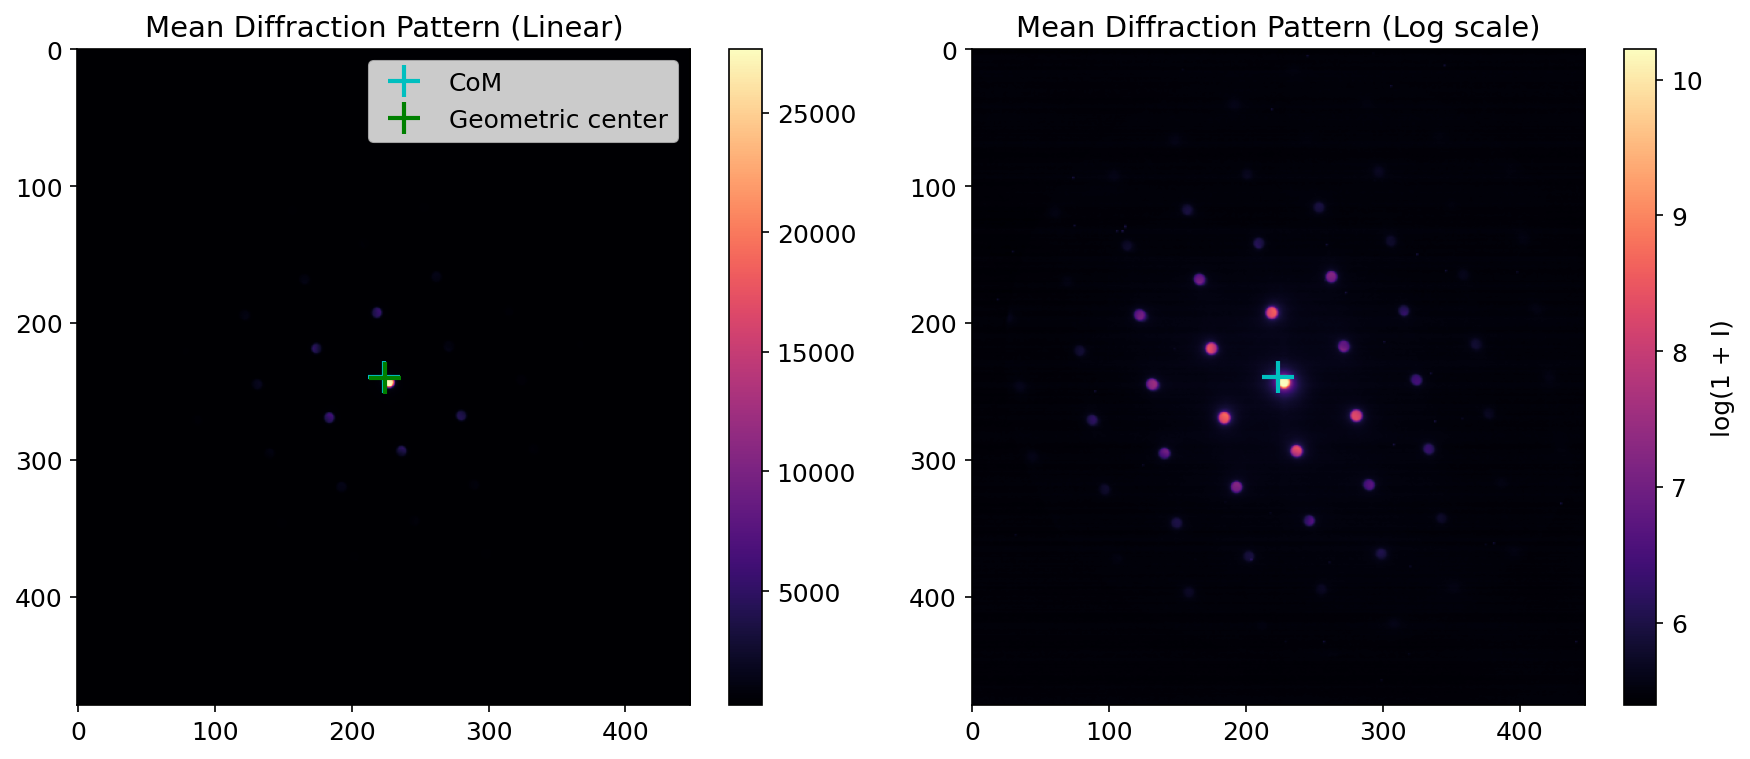

In [11]:
# Visualize the mean diffraction pattern
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Linear scale
im0 = axes[0].imshow(mean_dp, cmap='magma')
axes[0].plot(beam_center[0], beam_center[1], 'c+', markersize=15, markeredgewidth=2, label='CoM')
axes[0].plot(diff_x/2, diff_y/2, 'g+', markersize=15, markeredgewidth=2, label='Geometric center')
axes[0].set_title('Mean Diffraction Pattern (Linear)')
axes[0].legend()
plt.colorbar(im0, ax=axes[0])

# Log scale to see weaker features
im1 = axes[1].imshow(np.log1p(mean_dp), cmap='magma')
axes[1].plot(beam_center[0], beam_center[1], 'c+', markersize=15, markeredgewidth=2)
axes[1].set_title('Mean Diffraction Pattern (Log scale)')
plt.colorbar(im1, ax=axes[1], label='log(1 + I)')

plt.tight_layout()
plt.show()

Estimated BF detector radius: 10 pixels

Reciprocal space calibration:
  k per pixel: 0.1000 nm^-1/pixel
  q per pixel: 0.0100 A^-1/pixel
  theta per pixel: 0.400 mrad/pixel


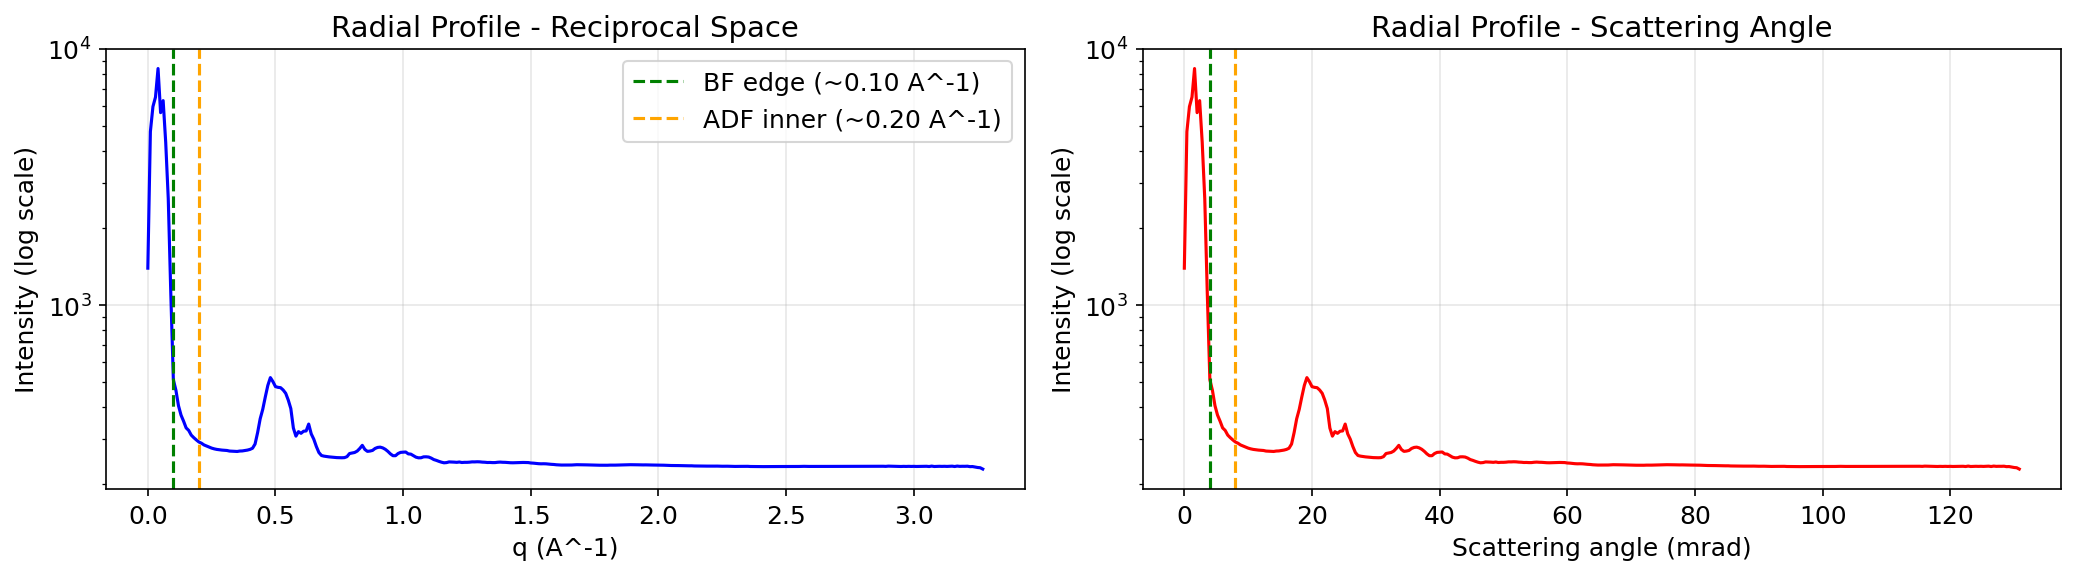

In [12]:
# Calculate radial profile to determine detector radii
radii, profile = calculate_radial_profile(mean_dp, beam_center)

# Normalize profile
profile_norm = profile / profile.max()

# Find where intensity drops to 10% of max (approximate BF edge)
bf_edge_idx = np.where(profile_norm < 0.1)[0]
if len(bf_edge_idx) > 0:
    bf_radius_estimate = bf_edge_idx[0]
else:
    bf_radius_estimate = 40

print(f"Estimated BF detector radius: {bf_radius_estimate} pixels")


k_pixel_inv_nm = calibration.get('k_pixel_inv_nm', 0.1)  # nm^-1 per pixel
mrad_per_pixel = calibration.get('mrad_per_pixel')

Q_PER_PIXEL_INV_A = k_pixel_inv_nm * 0.1  # convert nm^-1 -> A^-1
if mrad_per_pixel is None:
    # Approximate conversion for 200 kV: 1 mrad ? 0.025 A^-1
    mrad_per_pixel = Q_PER_PIXEL_INV_A / 0.025

print(f"\nReciprocal space calibration:")
print(f"  k per pixel: {k_pixel_inv_nm:.4f} nm^-1/pixel")
print(f"  q per pixel: {Q_PER_PIXEL_INV_A:.4f} A^-1/pixel")
print(f"  theta per pixel: {mrad_per_pixel:.3f} mrad/pixel")

# Convert radii to physical units
radii_q = radii * Q_PER_PIXEL_INV_A  # A^-1
radii_mrad = radii * mrad_per_pixel  # mrad

# Plot radial profile with physical units
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Left: q (A^-1) axis
ax1 = axes[0]
ax1.semilogy(radii_q, profile, 'b-', linewidth=1.5)
ax1.axvline(bf_radius_estimate * Q_PER_PIXEL_INV_A, color='g', linestyle='--', 
            label=f'BF edge (~{bf_radius_estimate * Q_PER_PIXEL_INV_A:.2f} A^-1)')
ax1.axvline((bf_radius_estimate + 10) * Q_PER_PIXEL_INV_A, color='orange', linestyle='--',
            label=f'ADF inner (~{(bf_radius_estimate + 10) * Q_PER_PIXEL_INV_A:.2f} A^-1)')
ax1.set_xlabel('q (A^-1)')
ax1.set_ylabel('Intensity (log scale)')
ax1.set_title('Radial Profile - Reciprocal Space')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: mrad axis
ax2 = axes[1]
ax2.semilogy(radii_mrad, profile, 'r-', linewidth=1.5)
ax2.axvline(bf_radius_estimate * mrad_per_pixel, color='g', linestyle='--')
ax2.axvline((bf_radius_estimate + 10) * mrad_per_pixel, color='orange', linestyle='--')
ax2.set_xlabel('Scattering angle (mrad)')
ax2.set_ylabel('Intensity (log scale)')
ax2.set_title('Radial Profile - Scattering Angle')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/radial_profile_physical_units.png', dpi=300, bbox_inches='tight')
plt.show()


In [13]:
# Task 3: Create Virtual Detectors

# Calculate maximum possible radius based on beam center position
cx, cy = beam_center
max_r = min(cx, cy, diff_x - 1 - cx, diff_y - 1 - cy)
print(f"Maximum possible radius: {max_r:.1f} pixels")

# Define detector parameters based on radial profile analysis
bf_outer_radius = max(9, bf_radius_estimate - 2)
adf_inner_radius = bf_outer_radius + 10
adf_outer_radius = adf_inner_radius + 80

# CLIP to max_r to avoid geometry validation failures
bf_outer_radius = min(bf_outer_radius, int(max_r) - 1)
adf_outer_radius = min(adf_outer_radius, int(max_r) - 1)
adf_inner_radius = min(adf_inner_radius, adf_outer_radius - 1)

# Sanity checks
if bf_outer_radius < 2:
    raise ValueError(f"BF outer radius too small: {bf_outer_radius}")
if adf_outer_radius <= adf_inner_radius:
    raise ValueError(f"ADF outer ({adf_outer_radius}) must be > inner ({adf_inner_radius})")

print(f"\nDetector parameters (after clipping to max_r):")
print(f"  BF: center=({cx:.1f}, {cy:.1f}), radius={bf_outer_radius}")
print(f"  ADF: center=({cx:.1f}, {cy:.1f}), inner={adf_inner_radius}, outer={adf_outer_radius}")

# Create virtual detectors
bf_detector = VirtualDetector(
    name='BF',
    center=beam_center,
    inner_radius=0,
    outer_radius=bf_outer_radius
)

adf_detector = VirtualDetector(
    name='ADF',
    center=beam_center,
    inner_radius=adf_inner_radius,
    outer_radius=adf_outer_radius
)

print(f"\n{bf_detector}")
print(f"{adf_detector}")

# Validate detector geometries (should pass after clipping)
print(f"\nBF geometry valid: {bf_detector.validate_geometry((diff_y, diff_x))}")
print(f"ADF geometry valid: {adf_detector.validate_geometry((diff_y, diff_x))}")

Maximum possible radius: 223.3 pixels

Detector parameters (after clipping to max_r):
  BF: center=(223.7, 239.7), radius=9
  ADF: center=(223.7, 239.7), inner=19, outer=99

VirtualDetector(name='BF', type='BF', center=(223.66021872286078, 239.74407595955844), inner_r=0, outer_r=9)
VirtualDetector(name='ADF', type='ADF', center=(223.66021872286078, 239.74407595955844), inner_r=19, outer_r=99)

BF geometry valid: True
ADF geometry valid: True


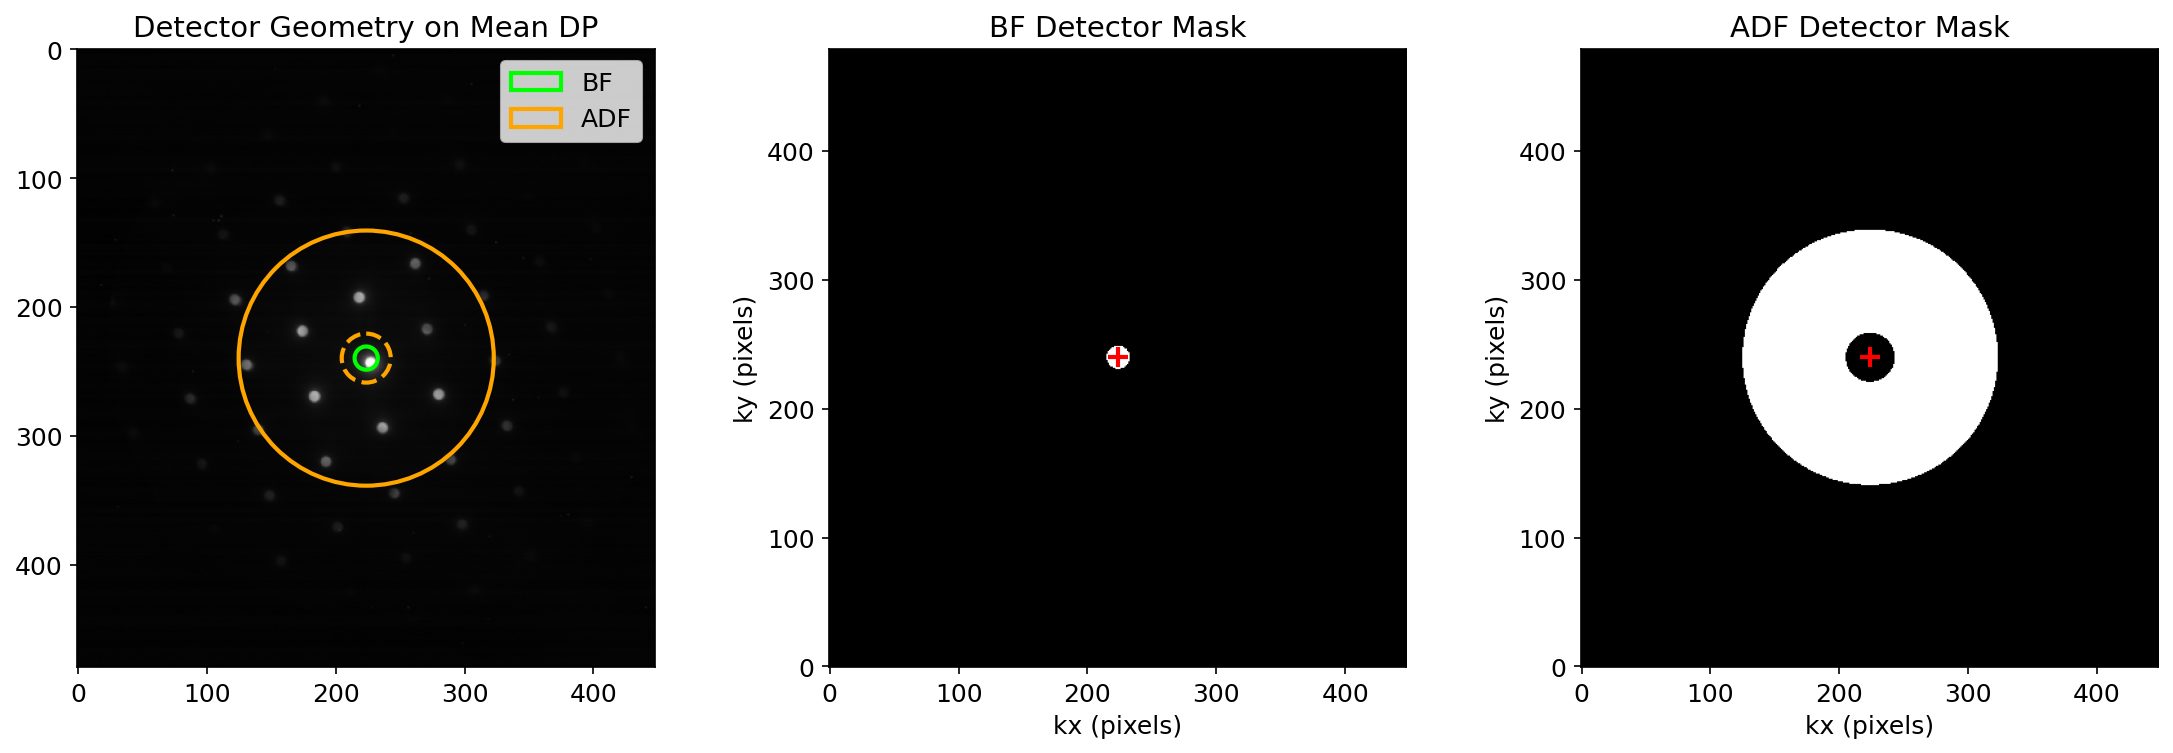

In [14]:
# Visualize detector masks overlaid on mean diffraction pattern
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Mean DP with detector overlays
ax = axes[0]
ax.imshow(np.log1p(mean_dp), cmap='gray')

# Add BF circle
bf_circle = Circle(beam_center, bf_outer_radius, fill=False, color='lime', linewidth=2, label='BF')
ax.add_patch(bf_circle)

# Add ADF annulus
adf_inner = Circle(beam_center, adf_inner_radius, fill=False, color='orange', linewidth=2, linestyle='--')
adf_outer = Circle(beam_center, adf_outer_radius, fill=False, color='orange', linewidth=2, label='ADF')
ax.add_patch(adf_inner)
ax.add_patch(adf_outer)

ax.set_title('Detector Geometry on Mean DP')
ax.legend(loc='upper right')

# BF mask
bf_detector.visualize_mask((diff_y, diff_x), ax=axes[1])

# ADF mask
adf_detector.visualize_mask((diff_y, diff_x), ax=axes[2])

plt.tight_layout()
plt.show()

In [15]:
# Run the analysis pipeline
print("Running analysis pipeline on Si-SiGe data...")

# Ensure calibration includes current beam center
calibration['beam_center'] = beam_center

# Use centered data_4d
results = run_pipeline(
    data_4d,
    [bf_detector, adf_detector],
    calibration=calibration,
    compute_stats=True,
    verbose=True
)

# Extract virtual images
bf_image = results['virtual_images']['BF']
adf_image = results['virtual_images']['ADF']

print(f"\nVirtual image shapes:")
print(f"  BF: {bf_image.shape}")
print(f"  ADF: {adf_image.shape}")


Running analysis pipeline on Si-SiGe data...
Running pipeline on data with shape: (77, 17, 480, 448)
  Scan dimensions: 77 x 17
  Diffraction dimensions: 480 x 448
  Number of detectors: 2

Applying detector: BF
  Virtual image range: [702416.00, 1756724.00]

Applying detector: ADF
  Virtual image range: [8393134.00, 9631234.00]

Computing diffraction statistics...
  Mean CoM: (223.66, 239.74)

Pipeline complete!

Virtual image shapes:
  BF: (77, 17)
  ADF: (77, 17)


In [16]:
# Task 4: Publication-quality visualization

def add_scale_bar(ax, image_shape, pixel_size_nm, scale_bar_length_nm=10, 
                  position='lower-left', color='white', fontsize=10):
    """
    Add a scale bar to an image.
    
    Parameters
    ----------
    ax : matplotlib axis
        Axis to add scale bar to
    image_shape : tuple
        (height, width) of image in pixels
    pixel_size_nm : float
        Size of each pixel in nm
    scale_bar_length_nm : float
        Desired scale bar length in nm
    position : str
        Position: 'lower-left', 'lower-right', 'upper-left', 'upper-right'
    color : str
        Color of scale bar and text
    fontsize : int
        Font size for label
    """
    height, width = image_shape
    scale_bar_pixels = scale_bar_length_nm / pixel_size_nm
    
    # Determine position
    margin = 0.05
    bar_height = 2  # pixels
    
    if 'left' in position:
        bar_x = width * margin
    else:
        bar_x = width * (1 - margin) - scale_bar_pixels
    
    if 'lower' in position:
        bar_y = height * (1 - margin) - bar_height
    else:
        bar_y = height * margin
    
    # Add scale bar rectangle
    scale_bar = Rectangle((bar_x, bar_y), scale_bar_pixels, bar_height,
                           fill=True, facecolor=color, edgecolor=color)
    ax.add_patch(scale_bar)
    
    # Add label
    text_y = bar_y - 3 if 'lower' in position else bar_y + bar_height + 3
    va = 'top' if 'lower' in position else 'bottom'
    ax.text(bar_x + scale_bar_pixels/2, text_y, f'{scale_bar_length_nm} nm',
            ha='center', va=va, color=color, fontsize=fontsize, fontweight='bold')

print(f"Image dimensions: {bf_image.shape}")
print(f"Field of view: {bf_image.shape[1] * scan_step_nm:.1f} x {bf_image.shape[0] * scan_step_nm:.1f} nm")

Image dimensions: (77, 17)
Field of view: 17.0 x 77.0 nm


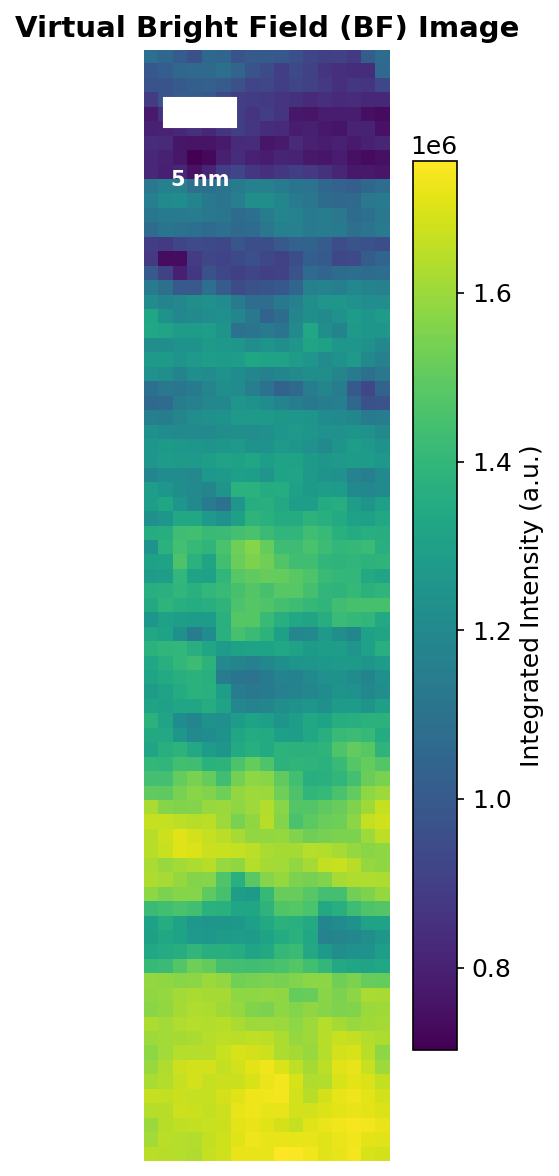

Saved: outputs/virtual_bf_image.png


In [17]:
# Create publication-quality BF image
fig, ax = plt.subplots(figsize=(8, 8))

im = ax.imshow(bf_image, cmap='viridis', origin='lower')
ax.set_title('Virtual Bright Field (BF) Image', fontsize=14, fontweight='bold')
ax.axis('off')

# Add scale bar
add_scale_bar(ax, bf_image.shape, scan_step_nm, scale_bar_length_nm=5)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.8, pad=0.02)
cbar.set_label('Integrated Intensity (a.u.)', fontsize=12)

plt.tight_layout()
plt.savefig('outputs/virtual_bf_image.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()
print("Saved: outputs/virtual_bf_image.png")

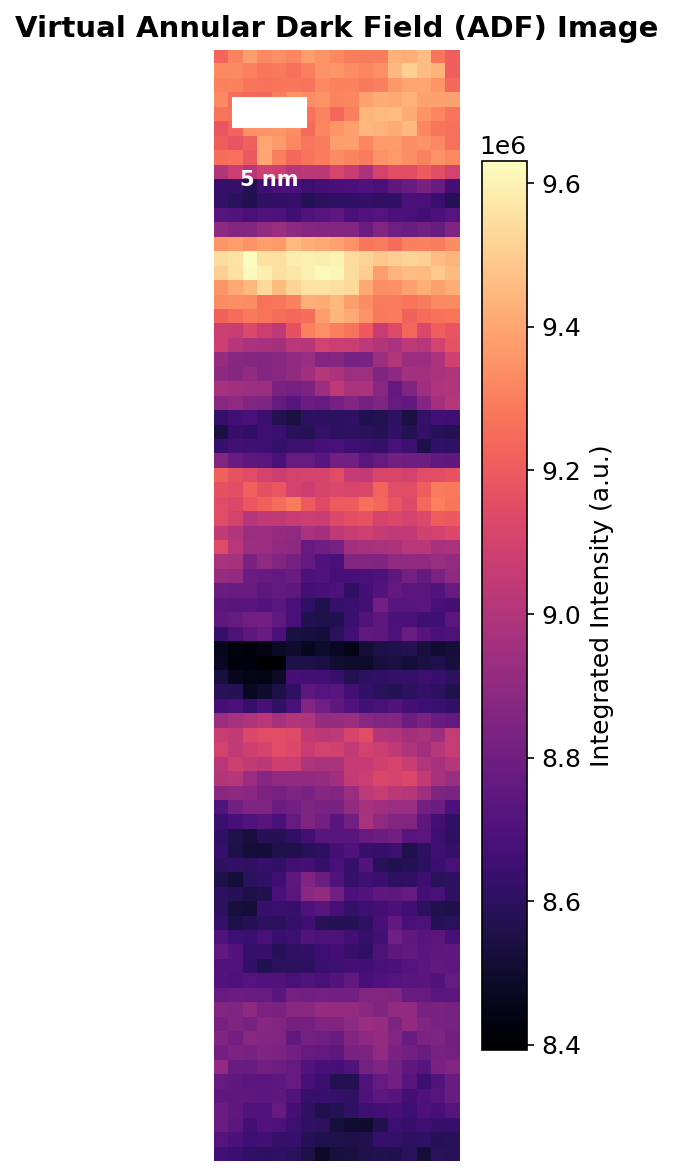

Saved: outputs/virtual_adf_image.png


In [18]:
# Create publication-quality ADF image
fig, ax = plt.subplots(figsize=(8, 8))

im = ax.imshow(adf_image, cmap='magma', origin='lower')
ax.set_title('Virtual Annular Dark Field (ADF) Image', fontsize=14, fontweight='bold')
ax.axis('off')

# Add scale bar
add_scale_bar(ax, adf_image.shape, scan_step_nm, scale_bar_length_nm=5)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.8, pad=0.02)
cbar.set_label('Integrated Intensity (a.u.)', fontsize=12)

plt.tight_layout()
plt.savefig('outputs/virtual_adf_image.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()
print("Saved: outputs/virtual_adf_image.png")

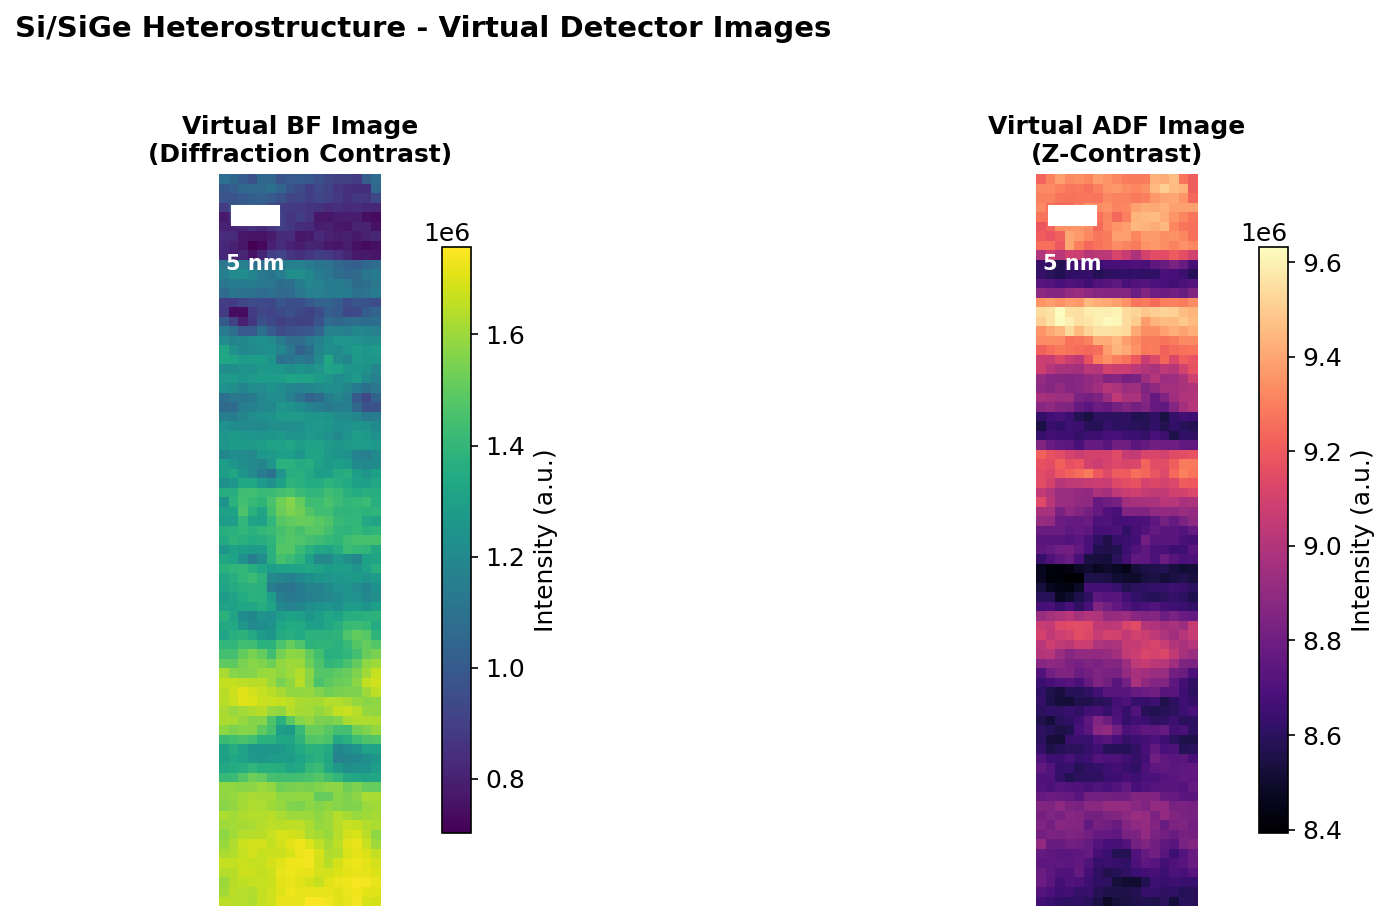

In [19]:
# Combined comparison figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# BF image
im0 = axes[0].imshow(bf_image, cmap='viridis', origin='lower')
axes[0].set_title('Virtual BF Image\n(Diffraction Contrast)', fontsize=12, fontweight='bold')
axes[0].axis('off')
add_scale_bar(axes[0], bf_image.shape, scan_step_nm, scale_bar_length_nm=5)
cbar0 = plt.colorbar(im0, ax=axes[0], shrink=0.8)
cbar0.set_label('Intensity (a.u.)')

# ADF image
im1 = axes[1].imshow(adf_image, cmap='magma', origin='lower')
axes[1].set_title('Virtual ADF Image\n(Z-Contrast)', fontsize=12, fontweight='bold')
axes[1].axis('off')
add_scale_bar(axes[1], adf_image.shape, scan_step_nm, scale_bar_length_nm=5)
cbar1 = plt.colorbar(im1, ax=axes[1], shrink=0.8)
cbar1.set_label('Intensity (a.u.)')

plt.suptitle('Si/SiGe Heterostructure - Virtual Detector Images', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('outputs/bf_adf_comparison.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

In [20]:
# Find the direction with maximum intensity variation (likely the interface)
# Check both horizontal and vertical profiles
h_profile_bf = np.mean(bf_image, axis=0)  # Average along y
v_profile_bf = np.mean(bf_image, axis=1)  # Average along x

h_profile_adf = np.mean(adf_image, axis=0)
v_profile_adf = np.mean(adf_image, axis=1)

# Determine which direction has more variation
h_var = np.std(h_profile_adf)
v_var = np.std(v_profile_adf)

print(f"Horizontal ADF variation: {h_var:.2f}")
print(f"Vertical ADF variation: {v_var:.2f}")

if h_var > v_var:
    profile_bf = h_profile_bf
    profile_adf = h_profile_adf
    profile_direction = 'horizontal'
    # Take a central horizontal line profile
    mid_y = bf_image.shape[0] // 2
    line_bf = bf_image[mid_y, :]
    line_adf = adf_image[mid_y, :]
    n_points = bf_image.shape[1]
else:
    profile_bf = v_profile_bf
    profile_adf = v_profile_adf
    profile_direction = 'vertical'
    # Take a central vertical line profile
    mid_x = bf_image.shape[1] // 2
    line_bf = bf_image[:, mid_x]
    line_adf = adf_image[:, mid_x]
    n_points = bf_image.shape[0]

print(f"Using {profile_direction} profile direction")

# Create position array in nm
position_nm = np.arange(n_points) * scan_step_nm

Horizontal ADF variation: 10626.82
Vertical ADF variation: 275388.85
Using vertical profile direction


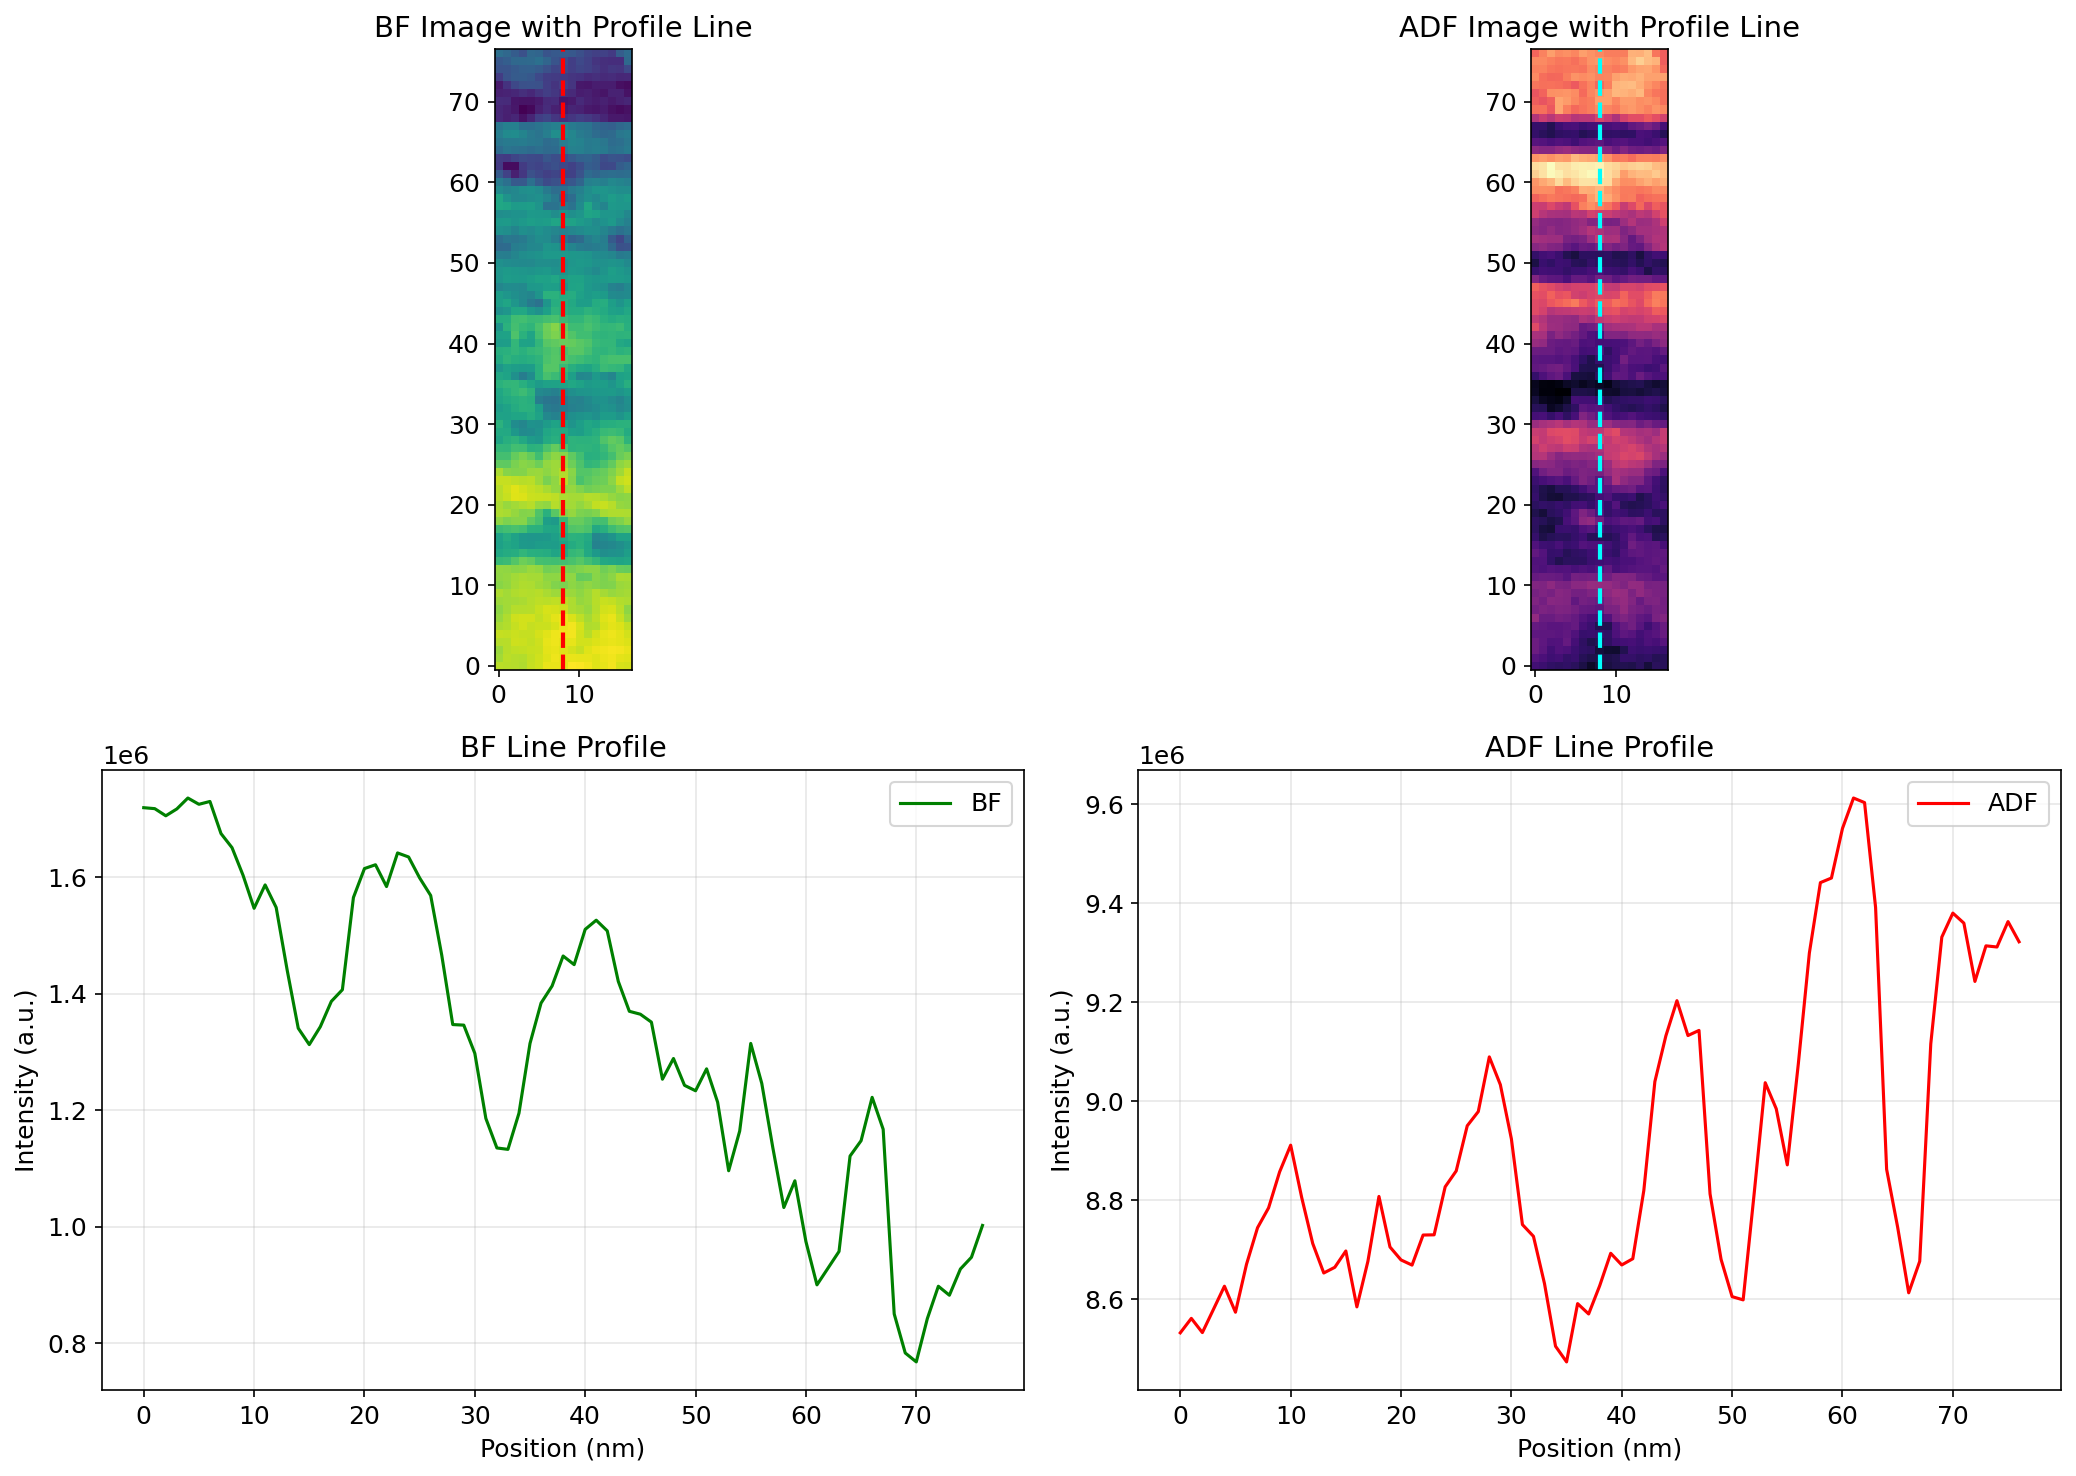

Saved: outputs/interface_line_profile.png


In [21]:
# Create line profile figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Show images with line position
# BF with line
axes[0, 0].imshow(bf_image, cmap='viridis', origin='lower')
if profile_direction == 'horizontal':
    axes[0, 0].axhline(mid_y, color='red', linewidth=2, linestyle='--')
else:
    axes[0, 0].axvline(mid_x, color='red', linewidth=2, linestyle='--')
axes[0, 0].set_title('BF Image with Profile Line')

# ADF with line
axes[0, 1].imshow(adf_image, cmap='magma', origin='lower')
if profile_direction == 'horizontal':
    axes[0, 1].axhline(mid_y, color='cyan', linewidth=2, linestyle='--')
else:
    axes[0, 1].axvline(mid_x, color='cyan', linewidth=2, linestyle='--')
axes[0, 1].set_title('ADF Image with Profile Line')

# Line profiles
# Normalize for comparison
line_bf_norm = (line_bf - line_bf.min()) / (line_bf.max() - line_bf.min())
line_adf_norm = (line_adf - line_adf.min()) / (line_adf.max() - line_adf.min())

axes[1, 0].plot(position_nm, line_bf, 'g-', linewidth=1.5, label='BF')
axes[1, 0].set_xlabel('Position (nm)')
axes[1, 0].set_ylabel('Intensity (a.u.)')
axes[1, 0].set_title('BF Line Profile')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(position_nm, line_adf, 'r-', linewidth=1.5, label='ADF')
axes[1, 1].set_xlabel('Position (nm)')
axes[1, 1].set_ylabel('Intensity (a.u.)')
axes[1, 1].set_title('ADF Line Profile')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/interface_line_profile.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()
print("Saved: outputs/interface_line_profile.png")

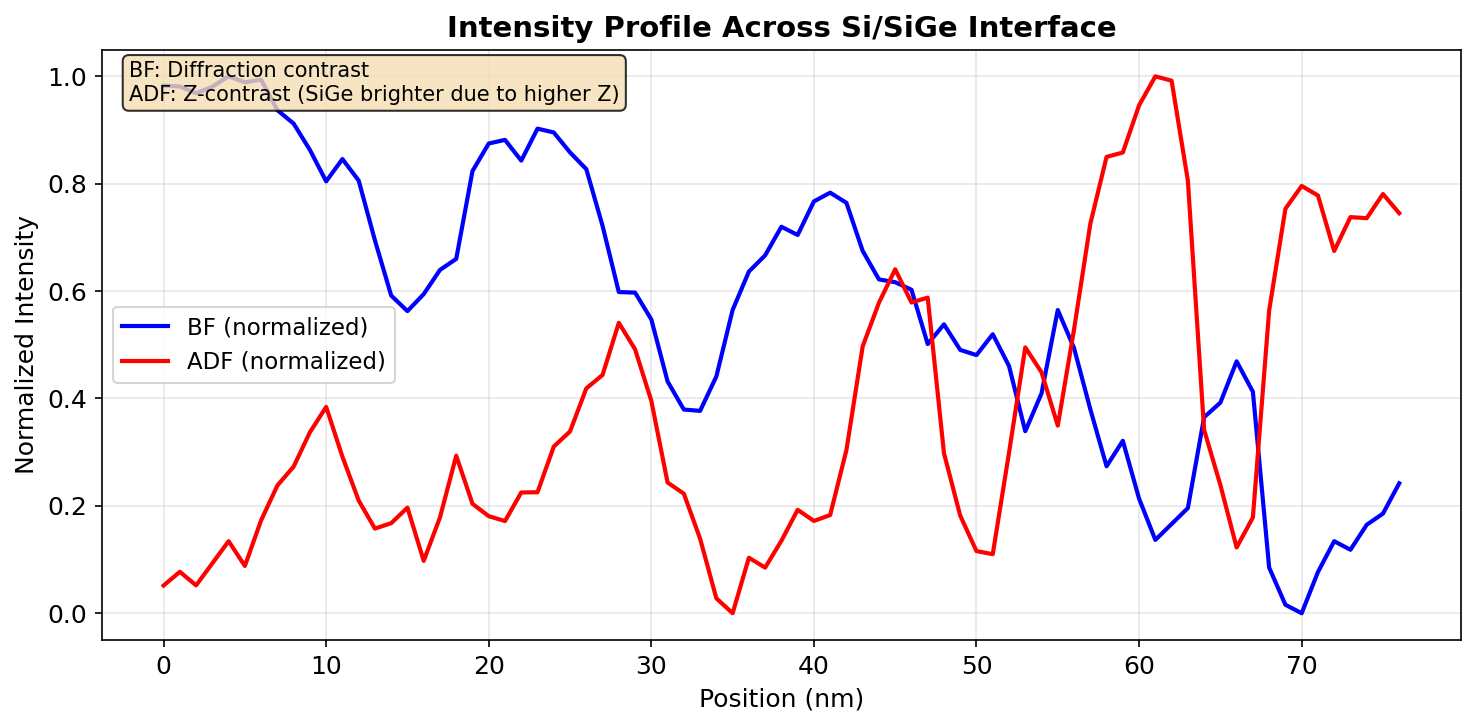

In [22]:
# Combined normalized line profile comparison
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(position_nm, line_bf_norm, 'b-', linewidth=2, label='BF (normalized)')
ax.plot(position_nm, line_adf_norm, 'r-', linewidth=2, label='ADF (normalized)')

ax.set_xlabel('Position (nm)', fontsize=12)
ax.set_ylabel('Normalized Intensity', fontsize=12)
ax.set_title('Intensity Profile Across Si/SiGe Interface', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Add annotation explaining the contrast
ax.text(0.02, 0.98, 'BF: Diffraction contrast\nADF: Z-contrast (SiGe brighter due to higher Z)',
        transform=ax.transAxes, verticalalignment='top', fontsize=10,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.savefig('outputs/normalized_line_profiles.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

Total intensity range: [5.37e+07, 5.52e+07]
CoM X range: [222.53, 224.54]
CoM Y range: [239.06, 240.38]


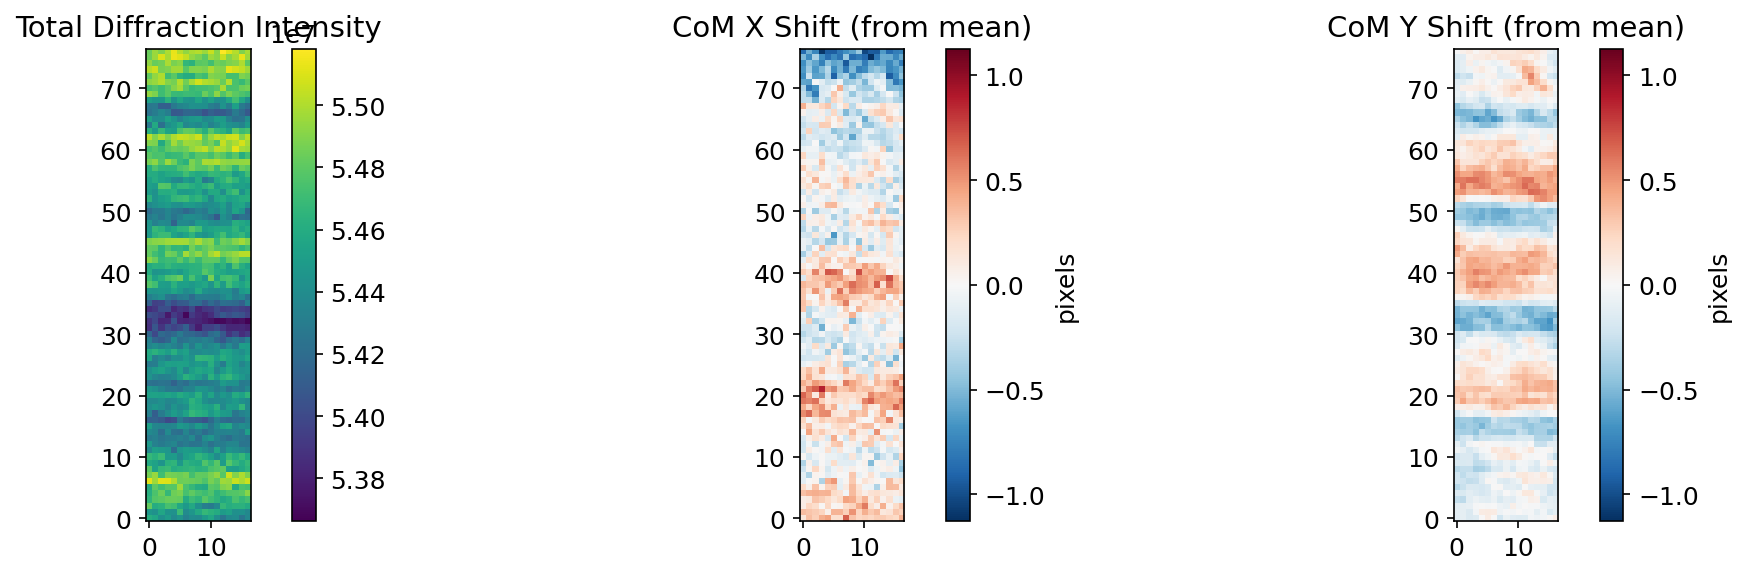

In [23]:
total_int = results['diffraction_stats']['total_intensity']
com_x = results['diffraction_stats']['com_x']
com_y = results['diffraction_stats']['com_y']

print(f"Total intensity range: [{total_int.min():.2e}, {total_int.max():.2e}]")
print(f"CoM X range: [{com_x.min():.2f}, {com_x.max():.2f}]")
print(f"CoM Y range: [{com_y.min():.2f}, {com_y.max():.2f}]")

# Visualize CoM shifts (indicates strain/electric fields)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

im0 = axes[0].imshow(total_int, cmap='viridis', origin='lower')
axes[0].set_title('Total Diffraction Intensity')
plt.colorbar(im0, ax=axes[0])

# Center the CoM colormap around the mean
com_x_centered = com_x - np.mean(com_x)
com_y_centered = com_y - np.mean(com_y)
vmax = max(np.abs(com_x_centered).max(), np.abs(com_y_centered).max())

im1 = axes[1].imshow(com_x_centered, cmap='RdBu_r', origin='lower', vmin=-vmax, vmax=vmax)
axes[1].set_title('CoM X Shift (from mean)')
plt.colorbar(im1, ax=axes[1], label='pixels')

im2 = axes[2].imshow(com_y_centered, cmap='RdBu_r', origin='lower', vmin=-vmax, vmax=vmax)
axes[2].set_title('CoM Y Shift (from mean)')
plt.colorbar(im2, ax=axes[2], label='pixels')

plt.tight_layout()
plt.show()

---
## Task 5: Summary and Discussion

### Virtual Detector Analysis Results

**Bright Field (BF) Image:**
- Captures the directly transmitted beam
- Shows **diffraction contrast** - variations due to crystallographic orientation and strain
- In Si/SiGe: reveals strain fields at the interface

**Annular Dark Field (ADF) Image:**
- Captures electrons scattered to higher angles
- More sensitive to scattering from higher atomic number elements
- SiGe region appears brighter than Si because Ge (Z=32) scatters more strongly than Si (Z=14)
- This qualitative Z-contrast enables identification of compositional variations

### Key Observations:
1. The ADF image clearly shows the Si/SiGe interface due to enhanced scattering from Ge
2. The BF image reveals diffraction contrast related to strain and crystal structure
3. Line profiles show intensity transitions at the interface
4. CoM maps can reveal electric field distributions and strain

### Calibration Note:
The reciprocal space calibration (q in Å⁻¹ or scattering angle in mrad) used in the radial profile 
is an assumed value for demonstration purposes. In practice, this should be determined from 
the camera length, detector pixel size, and electron wavelength.

In [24]:
# Final summary
print("\nFiles generated:")
print("  - outputs/virtual_bf_image.png")
print("  - outputs/virtual_adf_image.png")
print("  - outputs/bf_adf_comparison.png")
print("  - outputs/interface_line_profile.png")
print("  - outputs/normalized_line_profiles.png")

print("\nKey findings:")
print(f"  - Data shape: {dataset.data.shape}")
print(f"  - Beam center: ({beam_center[0]:.1f}, {beam_center[1]:.1f})")
print(f"  - BF detector radius: {bf_outer_radius} pixels")
print(f"  - ADF detector: {adf_inner_radius}-{adf_outer_radius} pixels")
print(f"  - Field of view: {bf_image.shape[1] * scan_step_nm:.1f} x {bf_image.shape[0] * scan_step_nm:.1f} nm")


Files generated:
  - outputs/virtual_bf_image.png
  - outputs/virtual_adf_image.png
  - outputs/bf_adf_comparison.png
  - outputs/interface_line_profile.png
  - outputs/normalized_line_profiles.png

Key findings:
  - Data shape: (480, 448, 77, 17)
  - Beam center: (223.7, 239.7)
  - BF detector radius: 9 pixels
  - ADF detector: 19-99 pixels
  - Field of view: 17.0 x 77.0 nm
